Имея базу смс-сообщений, разделенных по категориям спам и не спам, создадим и обучим модель, определяющую тип сообщения. Классифицируем каждое сообщение.


###  Загрузка данных

**импорт библиотек**


In [ ]:
from google.colab import files # работа с файлами
import numpy as np # работа с массивами numpy
import pandas as pd # работа с датафреймами
import matplotlib.pyplot as plt # вывод графиков
import os   # файловая система
import glob # файловая система
%matplotlib inline

from tensorflow.keras import utils # перевод значений в категориальные
from tensorflow.keras.models import Sequential # последовательная модель сети
from tensorflow.keras.optimizers import Adam # оптимайзер Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # слои сети
from tensorflow.keras.preprocessing.text import Tokenizer # преобразование текстов в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # работа с последовательностями
from tensorflow.keras.callbacks import ModelCheckpoint # для сохранения весов на эпохах

from sklearn.preprocessing import LabelEncoder # кодирование текстовых меток
from sklearn.model_selection import train_test_split # разделение на выборки
from google.colab import drive # работа с гугл диском
import random # для генерации случайных чисел
#import time # работа с системным временем
import seaborn as sns # вывод графики
sns.set_style('darkgrid') # стиль графиков

In [ ]:
# подключаем google drive
# drive.mount('/content/drive')

**загрузка данных**

In [ ]:
import gdown
# загрузка файла с сервера
gdown.download('http://m.ric.media/nu/12/psy.csv', None, quiet=True)

# загрузить датафрейм
data = pd.read_csv(open('/content/psy.csv', errors = 'replace'))
data = data.iloc[:, 3:5]
data['class'] = data['class'].astype('int') # булевые значения переведем в 0-1 (1 - значит spam)
data

,content,class
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...
345,How can this have 2 billion views when there's...,0
346,I don't now why I'm watching this in 2014﻿,0
347,subscribe to me for call of duty vids and give...,1
348,hi guys please my android photo editor downloa...,1


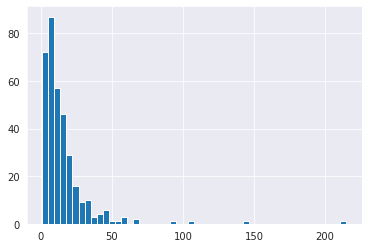

Средняя длина сообщения: 15.40


In [ ]:
texts = data['content'].values  # загрузим сообщения в numpy массив
classes = data['class'].values  # загрузим метки классов в numpy массив

maxWordsCount = 60000 # зададим размер словаря для BoW (малая база дает возможность сделать больше вектор)
nClasses = data['class'].nunique() # количество классов

# создаем токенайзер
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts) # обучаем токенайзер (создаем словарь частотности слов)
xAll = tokenizer.texts_to_sequences(texts) # преобразуем тексты в индексы слов (токенайзер выдает сразу numpy массив)
yAll = utils.to_categorical(classes, nClasses) # наши метки 

# выведем диаграмму частотности длин сообщений
textLens = [len(x) for x in xAll] # генерируем список длин каждого сообщения в базе
plt.hist(textLens,50) # выводим гистограмму списка длин сообщений
plt.show()

print('Средняя длина сообщения: {:.2f}'.format(np.array(textLens).mean()))

# ограничим длину всех сообщений до maxlen (те что меньше дополним нулями)
maxlen = 15 # максимальная длина сообщения 
xAll = pad_sequences(xAll, maxlen=maxlen) # numpy массив по 15 индексов в примере 

### Создаем выборки

In [ ]:
# создаем обучающую и проверочную выборки
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle=True)

# получим с помощью токенайзера вектора 0 и 1 для Bag of Words (последовательности в матрицу)
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
xVal01  = tokenizer.sequences_to_matrix(xVal.tolist())

In [ ]:
# проверим на баланс классов в выборке
# выведем количество примеров на класс в обучающей выборке
y_Train = np.argmax(yTrain, axis=1)
for i in range(nClasses): # пройдем количеством классов (писателей)
  Labels = np.where(y_Train==i)[0] # получим индексы примеров класса i на каждом шаге
  print(('не спам\t', 'спам\t')[i], ':', len(Labels))

не спам	 : 142
спам	 : 138


### Создание и обучение модели


Обучение (maxWordsCount=60000, maxlen=15):

Epoch 1/10
35/35 [==============================] - 4s 99ms/step - loss: 0.6651 - accuracy: 0.5857 - val_loss: 0.6535 - val_accuracy: 0.6429
Epoch 2/10
35/35 [==============================] - 3s 88ms/step - loss: 0.4193 - accuracy: 0.8036 - val_loss: 0.5857 - val_accuracy: 0.8714
Epoch 3/10
35/35 [==============================] - 3s 98ms/step - loss: 0.3364 - accuracy: 0.8786 - val_loss: 0.5230 - val_accuracy: 0.8857
Epoch 4/10
35/35 [==============================] - 3s 88ms/step - loss: 0.3194 - accuracy: 0.8464 - val_loss: 0.4554 - val_accuracy: 0.9429
Epoch 5/10
35/35 [==============================] - 3s 88ms/step - loss: 0.2802 - accuracy: 0.8857 - val_loss: 0.3780 - val_accuracy: 0.9857
Epoch 6/10
35/35 [==============================] - 3s 88ms/step - loss: 0.2756 - accuracy: 0.8893 - val_loss: 0.3234 - val_accuracy: 0.9857
Epoch 7/10
35/35 [==============================] - 3s 87ms/step - loss: 0.2344 - accuracy: 0.9250 - val_loss

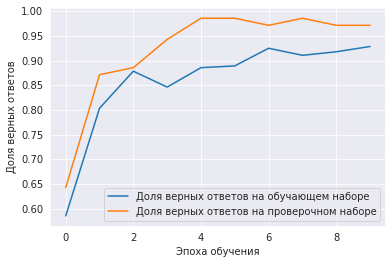

In [ ]:
# создание нейросети (последовательная модель)
model01 = Sequential()

# добавляем слои
model01.add(Dense(300, input_dim=maxWordsCount, activation='relu')) # полносвязный слой
model01.add(Dropout(0.9)) # слой регуляризации
#model01.add(Dense(100, activation='relu')) # полносвязный слой

model01.add(BatchNormalization()) # слой пакетной нормализации
model01.add(Dense(2, activation='softmax')) # полносвязный слой

# компилируем
model01.compile(loss='categorical_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'])

# отобразим данные модели
#model01.summary()

# вызов callback для сохранения весов каждой эпохи
mc = ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True)

# обучаем модель
print(f'\nОбучение (maxWordsCount={maxWordsCount}, maxlen={maxlen}):\n')
history = model01.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=8,
                      validation_data=(xVal01, yVal),
                      callbacks=[mc]
                      )

# отображаем график точности обучения
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# загрузим веса эпохи, которая показала лучший результат
#model01.load_weights('weights00000005.h5')

In [ ]:
# сохраним предварительные результаты
model01.save('spam.h5')

### Дообучение (уменьшим шаг обучения)


In [ ]:
# компилируем
model01.compile(loss='categorical_crossentropy',
                optimizer=Adam(0.0001),
                metrics=['accuracy'])

# отобразим данные модели
#model01.summary()

# вызов callback для сохранения весов каждой эпохи
mc = ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True)

# обучаем модель
print(f'\nОбучение (maxWordsCount={maxWordsCount}, maxlen={maxlen}):\n')
history = model01.fit(xTrain01,
                      yTrain,
                      epochs=10,
                      batch_size=8,
                      validation_data=(xVal01, yVal),
                      callbacks=[mc]
                      )

### Оценка точности сети и вывод нескольких примеров
В связи с тем, что мы обновляем ноутбук и загружаем модель с сервера заново, наша модель может распознать некоторые примеры из тестового набора на 100%, т.к. произошло очередное перемешивание выборок и эти примеры могли при обучении быть в обучающей выборке! 

In [ ]:
# оценить точность обученой сети
# scores[0] - loss сети
# scores[1] - процент правильно распознанных примеров
scores = model01.evaluate(xVal01, yVal, verbose=0)  
print('\nПроцент верных ответов на проверочной выборке: {:.2%}\n'\
      .format(scores[1]))
  
# сформируем список случайных 10 примеров из всей базы
indexes = [random.choice(range(xAll.shape[0])) for i in range(10)] # генерим 10 случайных индексов в список
xR01 = xAll[indexes] # берем 10 примеров в виде индексов слов из всей базы
xR01 = tokenizer.sequences_to_matrix(xR01.tolist()) # конвертируем список в формат BoW (вектора из 0 и 1)

# распознаем список
preds = model01.predict(xR01)    # распознаем
preds = np.argmax(preds, axis=1)  # переведем вектора в метки классов

# выведем результаты распознавания как “текст сообщения” - “категория сообщения, определенная нейронкой”
for i in range(10):
  ab = int(np.argmax(yAll[indexes[i]])==preds[i]) # верно распознали или нет (ошибочные будут большими буквами СПАМ)
  print('"{}" - "{}"'.format(data.loc[indexes[i], 'content'], ('не спам', ('СПАМ','спам')[ab])[preds[i]]))



Процент верных ответов на проверочной выборке: 100.00%

"http://flipagram.com/f/LUkA1QMrhF﻿" - "спам"
"You think you're smart?        Headbutt your face.﻿" - "не спам"
"Can anyone sub to my channel? :D﻿" - "спам"
"https://www.indiegogo.com/projects/cleaning-the-pan--2    please halp me  with my project﻿" - "спам"
"Haha its so funny to see the salt of westerners that top views of youtube  goes to video they dont even understand, keep the salt up!﻿" - "не спам"
"I hate this song! ﻿" - "не спам"
"Please subscribe to me﻿" - "спам"
"PSY - GANGNAM STYLE (강남스타일) M/V: http://youtu.be/9bZkp7q19f0﻿" - "не спам"
"just for test I have to say murdev.com" - "спам"
"Follow me on twitter &amp; IG : __killuminati94﻿" - "спам"


### Построим диаграмму частотности спама и не спама

In [ ]:
# выгрузим из базы нормальные сообщения и со спамом 
spam0 = data[data['class']==0]['content'].values
spam1 = data[data['class']==1]['content'].values
# переведем списки сообщений в токены
spam0indexes = tokenizer.texts_to_sequences(spam0)
spam1indexes = tokenizer.texts_to_sequences(spam1)
# конвертируем двумерные массивы списков в одномерные
ind0 = sum(spam0indexes,[])
ind1 = sum(spam1indexes,[])
# создадим датафреймы для двух списков
df0 = pd.DataFrame(ind0, columns=['token'])
df1 = pd.DataFrame(ind1, columns=['token'])
# посчитаем частотные распределения для токенов двух списков
df0counts = df0['token'].value_counts().reset_index()
df0counts.columns = ['token','frequency']
df1counts = df1['token'].value_counts().reset_index()
df1counts.columns = ['token','frequency']
# выгрузим временно токены в список (теперь они уникальны)
ind0_ = list(df0counts['token'])
ind1_ = list(df1counts['token'])
# преобразуем токены обратно токенайзеров в списки слов
text0_ = tokenizer.sequences_to_texts([ind0_])[0].split()
text1_ = tokenizer.sequences_to_texts([ind1_])[0].split()
# вернем в датафреймы списки с замененными токенами на слова
df0counts['token'] = text0_
df1counts['token'] = text1_

# выведем первые строки обоих списков
print('Список слов и частоты использования в нормальных сообщениях(первые 10):\n', df0counts.head(10))
print('Список слов и частоты использования в сообщениях со спамом(первые 10):\n', df1counts.head(10))

Список слов и частоты использования в нормальных сообщениях(первые 10):
      token  frequency
0      the         88
1     this         78
2    views         60
3       to         51
4        2         48
5       is         43
6        i         41
7  billion         38
8    video         34
9      and         28
Список слов и частоты использования в сообщениях со спамом(первые 10):
        token  frequency
0         my         81
1        and         69
2          i         69
3         to         68
4       http         63
5        com         53
6        www         51
7        you         49
8      check         47
9  subscribe         46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


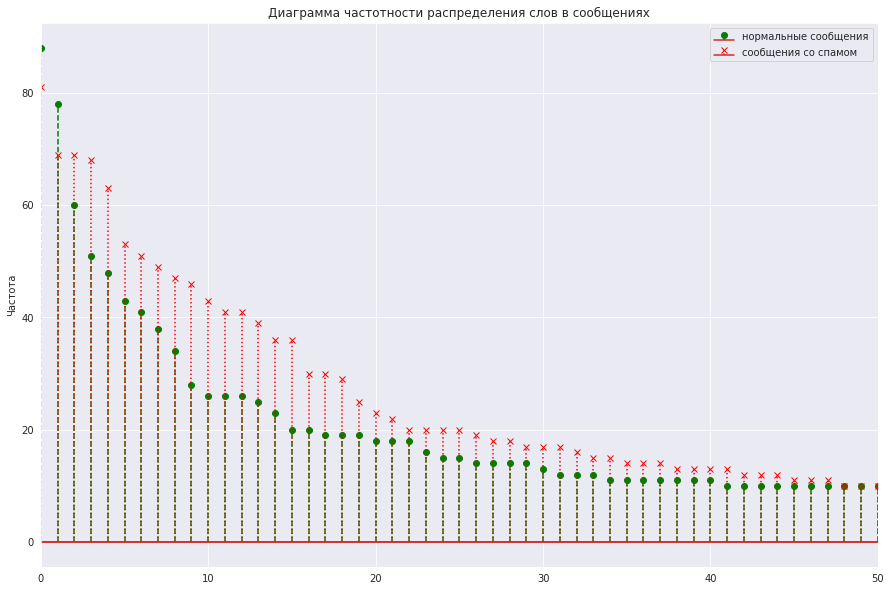

In [ ]:
# выведем диаграммы частотности нормальных сообщений и сообщений со спамом
plt.figure(figsize=(15,10))
plt.stem(df0counts['frequency'], linefmt='g--', markerfmt='go', label='нормальные сообщения', use_line_collection=False)
plt.stem(df1counts['frequency'], linefmt='r:', markerfmt='rx', label='сообщения со спамом', use_line_collection=False)
# plt.xlabel('Токены(слова)')
plt.ylabel('Частота')
plt.xlim([0,50])
plt.title('Диаграмма частотности распределения слов в сообщениях')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


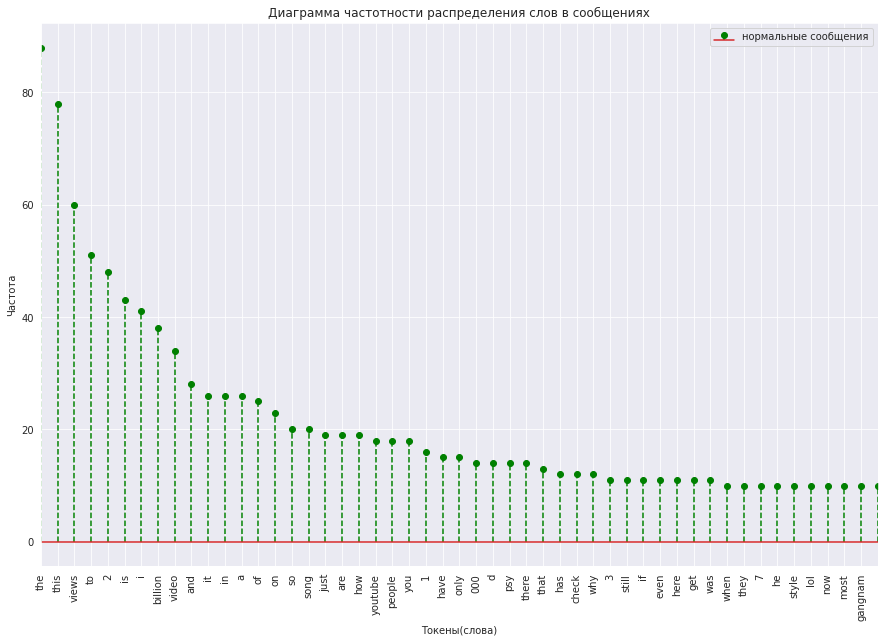

In [ ]:
# выведем диаграммы частотности нормальных сообщений (со словами)
plt.figure(figsize=(15,10))
plt.stem(df0counts['frequency'], linefmt='g--', markerfmt='go', label='нормальные сообщения', use_line_collection=False)
plt.xlabel('Токены(слова)')
plt.ylabel('Частота')
plt.xlim([0,50])
plt.xticks(range(50), list(df0counts['token'][0:50]), rotation = 90) 
plt.title('Диаграмма частотности распределения слов в сообщениях')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


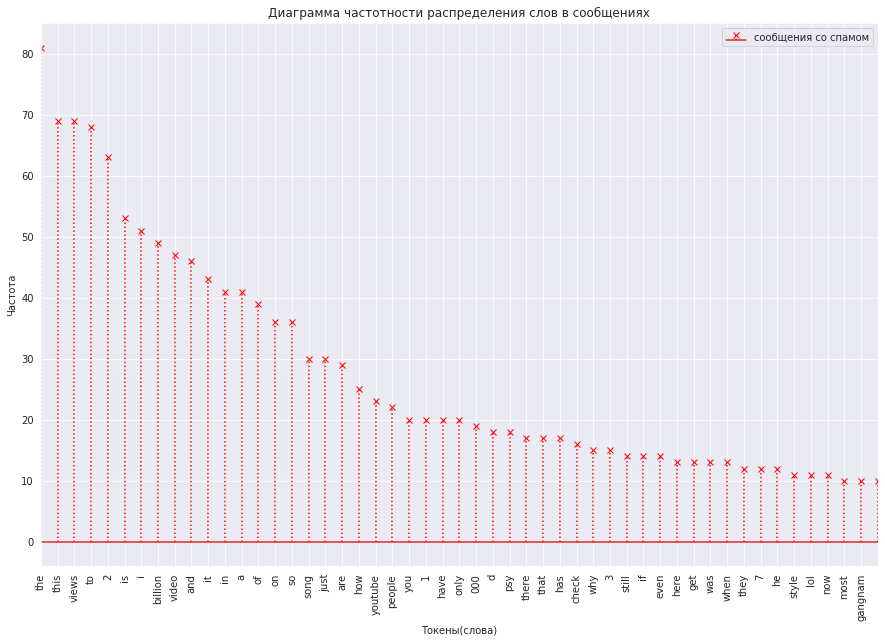

In [ ]:
# выведем диаграммы частотности сообщений со спамом (со словами)
plt.figure(figsize=(15,10))
plt.stem(df1counts['frequency'], linefmt='r:', markerfmt='rx', label='сообщения со спамом', use_line_collection=False)
plt.xlabel('Токены(слова)')
plt.ylabel('Частота')
plt.xlim([0,50])
plt.xticks(range(50), list(df0counts['token'][0:50]), rotation = 90) 
plt.title('Диаграмма частотности распределения слов в сообщениях')
plt.legend()
plt.show()